In [165]:
# Import the NetworkX package
import networkx as nx

import torch
print("PyTorch has version {}".format(torch.__version__))

import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv, SAGEConv

import torch.nn.functional as F

from torch_geometric.datasets import KarateClub

%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool


PyTorch has version 1.13.1+cu117


In [3]:
# Helper function for visualization.

# Visualization function for NX graph or PyTorch tensor
def visualize(G, h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=True,
                         node_color=color, cmap="Set2")
    plt.show()

## Dataset

In [4]:
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [5]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [6]:
print(data.x.shape)
data.x

torch.Size([34, 34])


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])

In [7]:
print(data.y.shape)
data.y

torch.Size([34])


tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [8]:
print(data.edge_index.shape)
data.edge_index

torch.Size([2, 156])


tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [9]:
data.edge_index.t()

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

In [108]:
print(data.train_mask.shape)
data.train_mask

torch.Size([34])


tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [109]:
# The adjacency matrix can be inferred from the edge_index with a utility function.

from torch_geometric.utils import to_dense_adj

A = to_dense_adj(data.edge_index)[0].numpy().astype(int)
print(f'A = {A.shape}')
print(A)

A = (34, 34)
[[0 1 1 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 1 0 ... 0 1 0]
 ...
 [1 0 0 ... 0 1 1]
 [0 0 1 ... 1 0 1]
 [0 0 0 ... 1 1 0]]


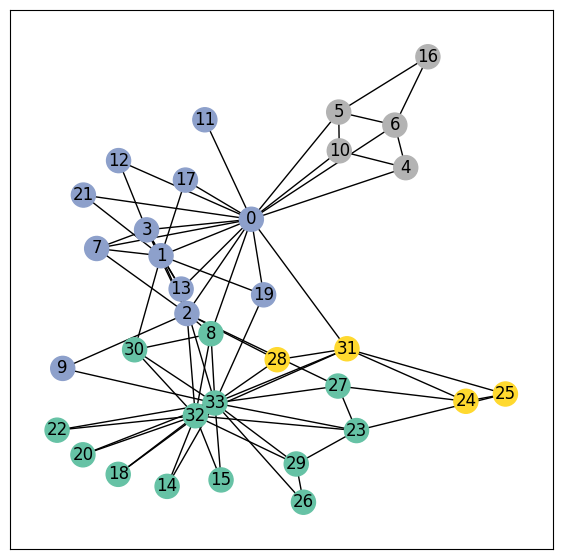

In [110]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, None, color=data.y)

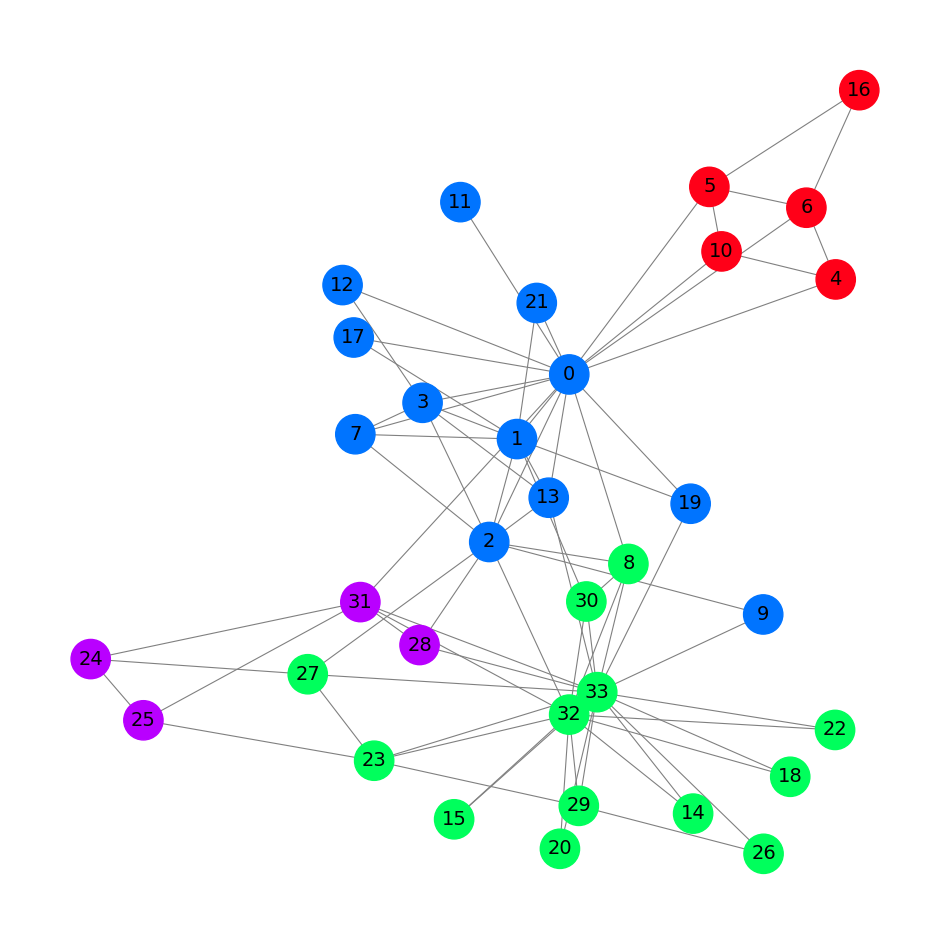

In [111]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=True,
                node_size=800,
                node_color=data.y,
                cmap="hsv",
                vmin=-2,
                vmax=3,
                width=0.8,
                edge_color="grey",
                font_size=14
                )
plt.show()

## Graph Convolutional Network (GCN)

In [14]:
import torch
torchversion = torch.__version__

from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.gcn = GCNConv(dataset.num_features, 3)
        self.out = Linear(3, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.gcn(x, edge_index)
        h = h.relu()
        z = self.out(h)
        return z, h

model = GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [155]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        # torch.manual_seed(12345)
        self.conv1 = GCNConv(num_features, 8)
        self.conv2 = GCNConv(8, 4)
        self.conv3 = GCNConv(4, 3)
        self.classifier = Linear(3, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.
        
        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h # out, h

gcn = GCN(num_features=dataset.num_features, num_classes=dataset.num_classes)
print(gcn)

GCN(
  (conv1): GCNConv(34, 8)
  (conv2): GCNConv(8, 4)
  (conv3): GCNConv(4, 3)
  (classifier): Linear(in_features=3, out_features=4, bias=True)
)


Embedding shape: [34, 3]


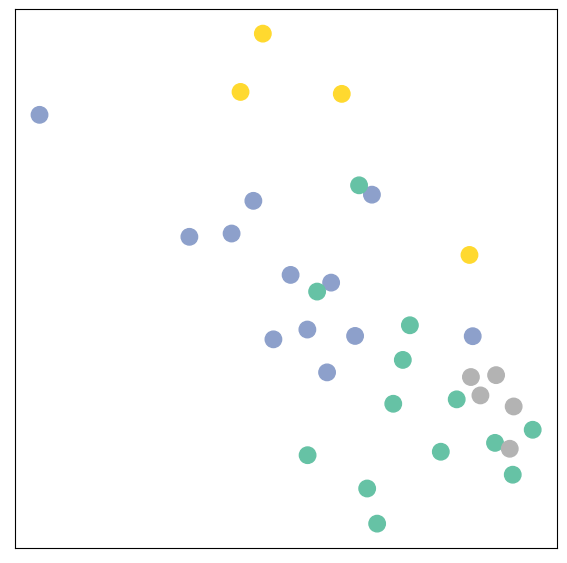

In [156]:
_, h = gcn(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(None, h, color=data.y)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    z, h = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(loss)
    accuracies.append(acc)
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

In [157]:
embeddings = []
losses = []
epochs = range(1, 201)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(gcn.parameters(), lr=0.02)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = gcn(data.x, data.edge_index)  # Perform a single forward pass.
    # loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss = criterion(out, data.y)
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in epochs:
    loss, h = train(data)
    
    losses.append(loss)
    embeddings.append(h)

    """ if epoch % 10 == 0:
        visualize(None, h, color=data.y, epoch=epoch, loss=loss)
        # time.sleep(0.3) """
    print(f"Epoch: {epoch}\tLoss: {loss:4f}")

Epoch: 1	Loss: 1.345326
Epoch: 2	Loss: 1.323181
Epoch: 3	Loss: 1.302610
Epoch: 4	Loss: 1.282580
Epoch: 5	Loss: 1.262928
Epoch: 6	Loss: 1.243330
Epoch: 7	Loss: 1.223378
Epoch: 8	Loss: 1.202760
Epoch: 9	Loss: 1.180610
Epoch: 10	Loss: 1.154821
Epoch: 11	Loss: 1.123121
Epoch: 12	Loss: 1.084385
Epoch: 13	Loss: 1.039176
Epoch: 14	Loss: 0.989734
Epoch: 15	Loss: 0.939311
Epoch: 16	Loss: 0.890820
Epoch: 17	Loss: 0.845423
Epoch: 18	Loss: 0.802265
Epoch: 19	Loss: 0.759746
Epoch: 20	Loss: 0.717154
Epoch: 21	Loss: 0.675187
Epoch: 22	Loss: 0.635185
Epoch: 23	Loss: 0.598290
Epoch: 24	Loss: 0.565061
Epoch: 25	Loss: 0.535413
Epoch: 26	Loss: 0.508794
Epoch: 27	Loss: 0.484498
Epoch: 28	Loss: 0.461946
Epoch: 29	Loss: 0.440784
Epoch: 30	Loss: 0.420828
Epoch: 31	Loss: 0.401972
Epoch: 32	Loss: 0.384138
Epoch: 33	Loss: 0.367255
Epoch: 34	Loss: 0.351256
Epoch: 35	Loss: 0.336070
Epoch: 36	Loss: 0.321618
Epoch: 37	Loss: 0.307813
Epoch: 38	Loss: 0.294581
Epoch: 39	Loss: 0.281870
Epoch: 40	Loss: 0.269661
Epoch: 41

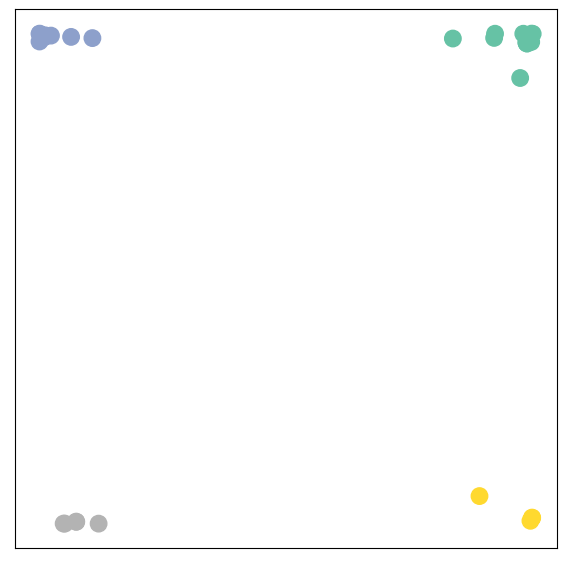

In [158]:
visualize(None, h, color=data.y)

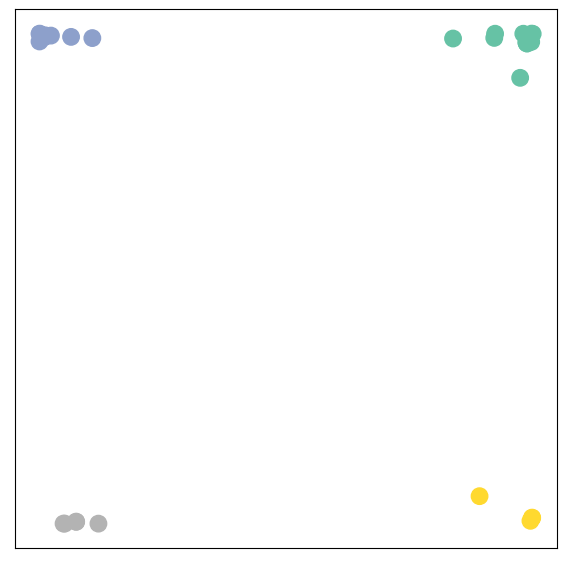

In [159]:
# Get embeddings
_, h_ = gcn(data.x, data.edge_index)
visualize(None, h_, color=data.y)

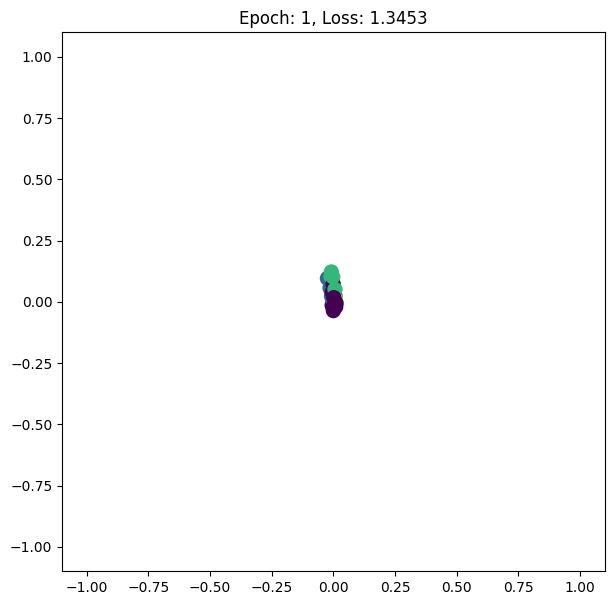

In [160]:
import matplotlib.animation as animation

def animate(i):
    ax.clear()
    h = embeddings[i]
    h = h.detach().numpy()
    ax.scatter(h[:, 0], h[:, 1], c=data.y, s=100)
    ax.set_title(f'Epoch: {epochs[i]}, Loss: {losses[i].item():.4f}')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])

fig = plt.figure(figsize=(7, 7))
ax = plt.axes()
anim = animation.FuncAnimation(fig, animate, frames=len(epochs), repeat=False)
# plt.show()

In [161]:
from IPython import display

video = anim.to_html5_video()
html_code = display.HTML(video)
display.display(html_code)

In [22]:
# gif_writer = animation.PillowWriter(fps=20)
# anim.save('embeddings.gif', writer=gif_writer)

In [66]:
def plot_embedding_3d(h):
    if torch.is_tensor(h):
        embed = h.detach().cpu().numpy()
    else:
        embed = h

    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    ax.patch.set_alpha(0)
    plt.tick_params(left=False,
                    bottom=False,
                    labelleft=False,
                    labelbottom=False)
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
            s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)

    plt.show()

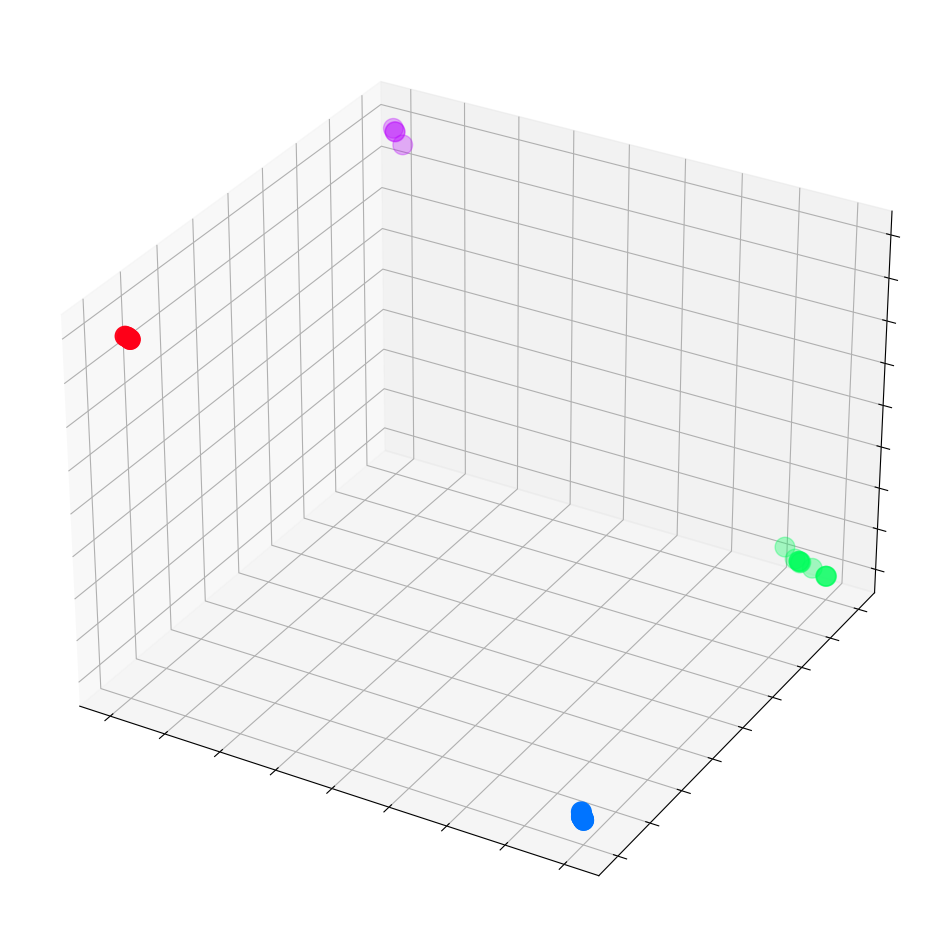

In [42]:
plot_embedding_3d(h)

In [24]:
%%capture
import numpy as np

from IPython.display import HTML
from matplotlib import animation
plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    embed = embeddings[i].detach().cpu().numpy()
    ax.clear()
    ax.scatter(embed[:, 0], embed[:, 1], embed[:, 2],
           s=200, c=data.y, cmap="hsv", vmin=-2, vmax=3)
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f}',
              fontsize=18, pad=40)

fig = plt.figure(figsize=(10, 10))
plt.axis('off')
ax = fig.add_subplot(projection='3d')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)

anim = animation.FuncAnimation(fig, animate, \
              np.arange(0, 200, 10), interval=800, repeat=False)
html = HTML(anim.to_html5_video())

In [25]:
display.display(html)

## Graph Attention Network (GAT)

In [53]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1), h

def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out, h = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        ## val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        ## val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
        val_loss = 1
        val_acc = 1

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

In [54]:
# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
_, h = train(gat, data)

# Test
## acc = test(gat, data)
## print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(34, 8, heads=8)
  (gat2): GATv2Conv(64, 4, heads=1)
)
Epoch   0 | Train Loss: 1.405 | Train Acc:  25.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  10 | Train Loss: 1.162 | Train Acc:  75.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  20 | Train Loss: 0.898 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  30 | Train Loss: 0.728 | Train Acc:  75.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  40 | Train Loss: 0.559 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  50 | Train Loss: 0.339 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  60 | Train Loss: 0.148 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  70 | Train Loss: 0.105 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  80 | Train Loss: 0.038 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch  90 | Train Loss: 0.022 | Train Acc: 100.00% | Val Loss: 1.00 | Val Acc: 100.00%
Epoch 100 | Train Loss: 0.024 | Train Acc: 100.00% 

In [55]:
h.shape

torch.Size([34, 4])

In [67]:
# Get embeddings
_, h = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=3, learning_rate='auto',
         init='pca').fit_transform(h.detach())

In [68]:
tsne

array([[  26.838476 , -126.0552   ,   60.086292 ],
       [ -86.307976 ,   33.84468  ,  -91.63408  ],
       [  28.235067 ,    5.4352646,  -43.281143 ],
       [  32.773293 ,  -68.53547  ,  -99.603745 ],
       [  37.68947  ,   50.84994  , -138.15517  ],
       [  -3.3802903,  102.26853  ,  -89.99519  ],
       [  19.450409 , -139.22627  ,  -39.89312  ],
       [ -49.283962 ,  -85.55214  ,   74.41148  ],
       [ -88.7909   ,   16.173525 ,  109.54865  ],
       [-108.787384 ,  -38.62592  ,   45.986748 ],
       [ -58.733685 ,  105.995575 ,   60.975697 ],
       [ 117.57683  ,   88.5389   ,   13.211663 ],
       [ -83.5044   ,  122.30167  ,  -32.810524 ],
       [ -18.166807 ,   -6.2660723, -107.88957  ],
       [ -57.25014  ,  -77.83721  ,  -75.26363  ],
       [  27.535192 ,  -35.36227  ,   52.86449  ],
       [ -59.000343 , -133.80707  ,   -2.4115908],
       [  97.31075  ,  -13.874813 ,  -88.733055 ],
       [  -2.444255 ,  -33.844116 ,  126.27702  ],
       [  -7.8850756,   52.2664

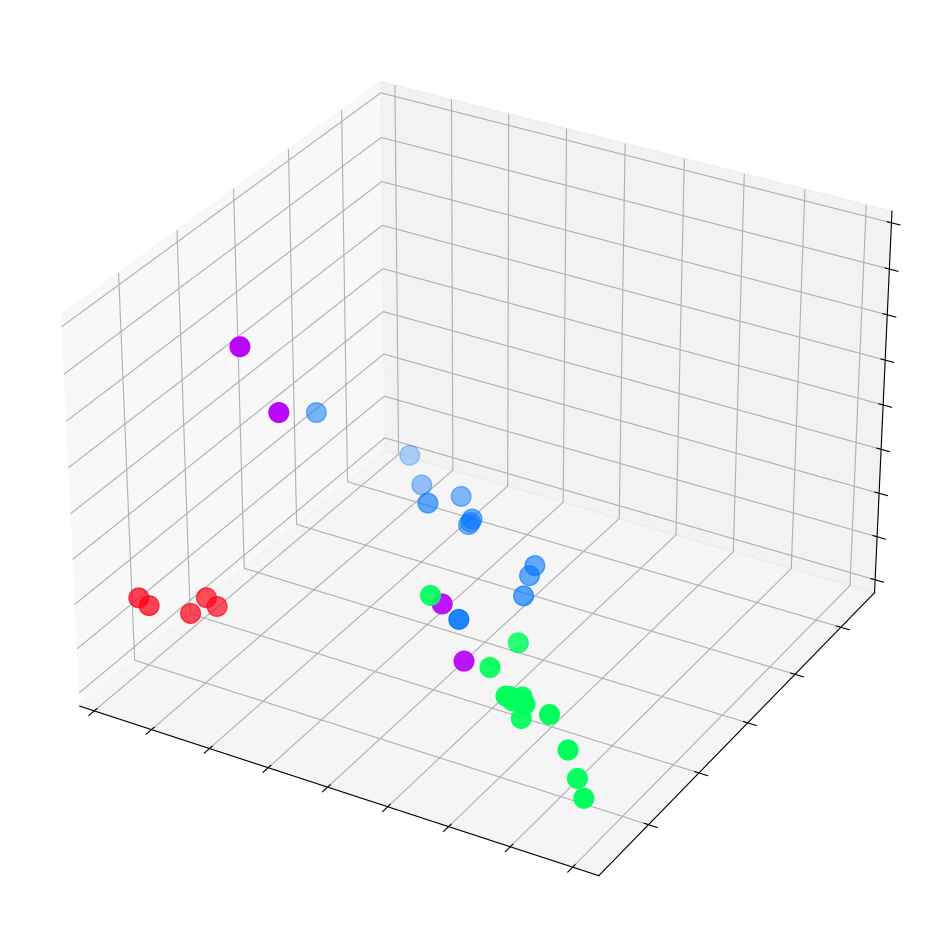

In [70]:
plot_embedding_3d(h)

## Graph SAGE

In [179]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=8,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

Subgraph 0: Data(x=[31, 34], edge_index=[2, 75], y=[31], train_mask=[31], input_id=[4], batch_size=4)


In [172]:
dataset

KarateClub()

In [178]:
from torch_geometric.loader import DataLoader

# Create mini-batches
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

print('\nTrain loader:')
for i, subgraph in enumerate(train_loader):
    print(f' - Subgraph {i}: {subgraph}')


Train loader:
 - Subgraph 0: DataBatch(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34], batch=[34], ptr=[2])


In [96]:
class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1), h

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out, h = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        """ val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%') """
    return h

In [98]:
# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
h_ = graphsage.fit(data, 200)

# Test
## print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(34, 64, aggr=mean)
  (sage2): SAGEConv(64, 4, aggr=mean)
)


In [99]:
# Get embeddings
_, h = graphsage(data.x, data.edge_index)

In [104]:
print(h.shape)
h

torch.Size([34, 4])


tensor([[-2.3969,  4.0207, -3.6919, -4.4235],
        [ 1.1195,  0.2853, -3.8043, -2.6652],
        [-0.7175, -1.1320, -0.3589, -3.4829],
        [ 0.3657, -0.2026, -3.2881, -1.7922],
        [-2.9344, -3.2683, -3.9295,  4.8443],
        [-1.9325, -1.8225, -2.8817,  1.0639],
        [-3.0937,  1.7745, -3.9365, -1.6667],
        [ 1.7722,  0.0669, -3.5613, -2.8726],
        [ 6.3158, -4.7513, -2.2035, -3.2441],
        [ 3.4861, -0.8799, -3.3972, -3.9668],
        [-2.7141,  1.8198, -3.2682, -1.4082],
        [-0.1257, -3.1922, -2.8593,  1.5579],
        [ 0.5981, -0.3978, -3.1345, -1.2053],
        [ 2.7247, -1.9600, -3.9495, -2.4985],
        [ 3.2607, -1.4834, -2.0987, -3.9263],
        [ 3.8070, -2.5276, -2.8669, -4.0206],
        [-3.7750, -0.2278, -3.2214,  1.1087],
        [-0.2882, -1.6073, -3.4700,  0.5999],
        [ 3.8384, -2.0094, -1.6225, -4.1064],
        [ 1.6261, -3.3231, -2.0498, -0.9024],
        [ 4.5439, -3.2539, -1.8846, -3.9295],
        [ 0.4935, -1.9500, -3.5375

In [106]:
print(h_.shape)
h_

torch.Size([30, 4])


tensor([[-2.5191,  4.3238, -2.7446, -5.0661],
        [-4.1477, -1.3379, -4.7382,  3.9623],
        [ 5.0040, -3.0383, -2.1887, -2.9690],
        [-5.0740, -2.3801,  5.9244, -5.5028],
        [ 1.6352, -1.6298, -2.7934, -2.2741],
        [ 0.6762, -2.3274, -1.9909, -0.6117],
        [-1.3453, -0.6847, -2.3908,  0.9221],
        [ 0.7201, -0.8484, -4.9343, -0.3658],
        [-1.2519,  1.2665, -3.7437, -1.6391],
        [-2.6503,  1.1321, -3.2509, -0.1812],
        [-1.1731, -1.8511, -0.7858, -2.6714],
        [ 1.4436, -0.2099, -1.7114, -3.6173],
        [-0.8318, -0.2528, -0.7071, -2.1669],
        [-0.5080, -0.3494, -1.1846, -2.3863],
        [ 1.7023, -1.9270, -1.6121, -2.6956],
        [-0.3424, -1.4484, -0.8881, -2.4072],
        [ 2.9704, -2.0487, -1.5887, -2.9592],
        [-0.4913, -0.3557, -1.5028,  0.0279],
        [-0.4950, -1.2413, -0.5909, -0.4886],
        [-1.3968,  0.1246, -0.3058, -0.5708],
        [-0.3313, -0.3215, -0.6077, -0.9790],
        [-1.5026, -0.5066, -0.4965

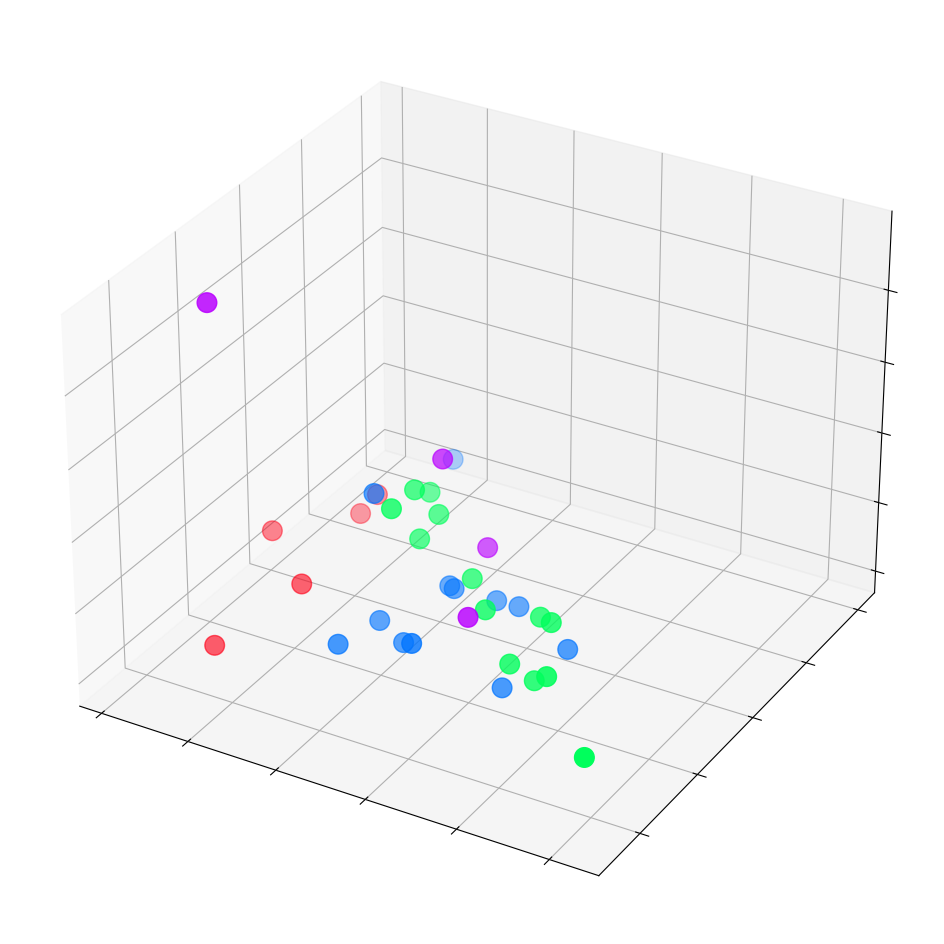

In [102]:
plot_embedding_3d(h)

ValueError: 'c' argument has 34 elements, which is inconsistent with 'x' and 'y' with size 30.

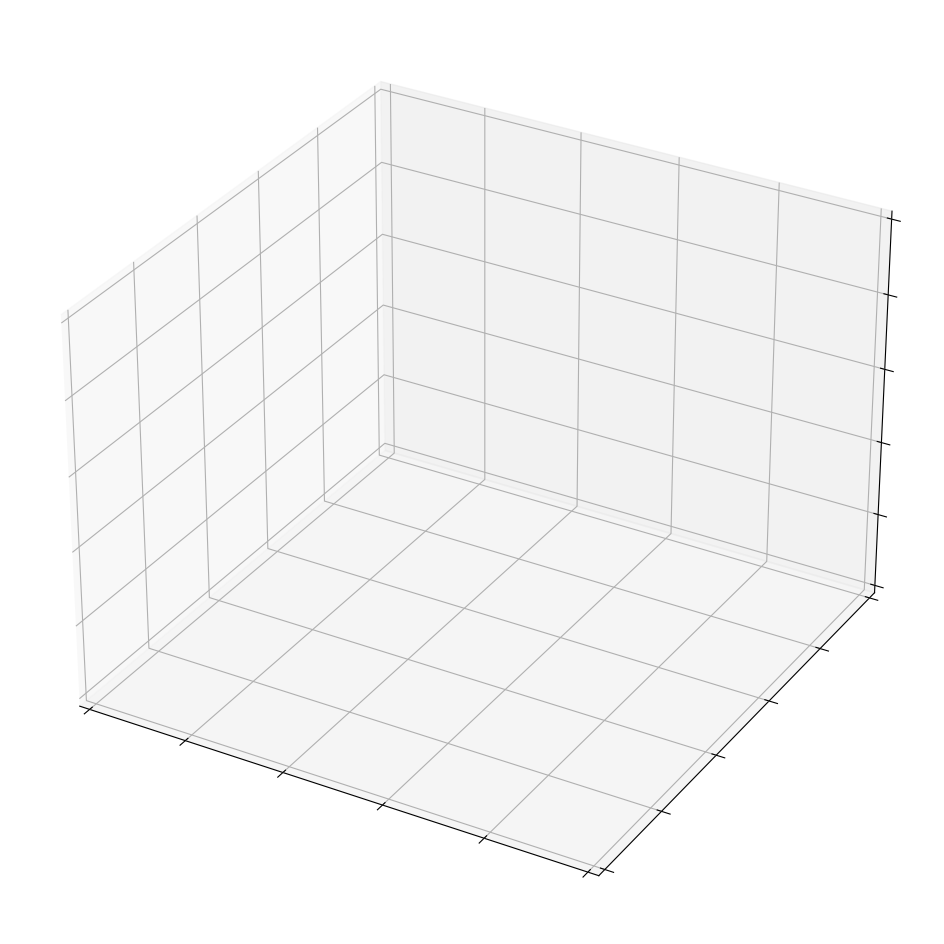

In [103]:
plot_embedding_3d(h_)

## Graph Isomorphism Network (GIN)

In [187]:
class GIN(torch.nn.Module):
    """GIN"""
    def __init__(self, dim_h):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(dataset.num_node_features, dim_h),
                       BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(dim_h, dim_h), BatchNorm1d(dim_h), ReLU(),
                       Linear(dim_h, dim_h), ReLU()))
        self.lin1 = Linear(dim_h*3, dim_h*3)
        self.lin2 = Linear(dim_h*3, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        # Node embeddings 
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)

        # Graph-level readout
        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)

        # Concatenate graph embeddings
        h = torch.cat((h1, h2, h3), dim=1)

        # Classifier
        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return F.log_softmax(h, dim=1), h

gin = GIN(dim_h=32)
print(gin)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=34, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=96, out_features=96, bias=True)
  (lin2): Linear(in_features=96, out_features=4, bias=True)
)


In [189]:
def train(model, loader):
	criterion = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
	epochs = 200

	model.train()
	for epoch in range(epochs+1):
		total_loss = 0
		acc = 0
		val_loss = 0
		val_acc = 0

		# Train on batches
		## for data in loader:
		optimizer.zero_grad()
		out, h = model(data.x, data.edge_index, data.batch)
		loss = criterion(out, data.y)
		## total_loss += loss / len(loader)
		## acc += accuracy(out.argmax(dim=1), data.y) / len(loader)
		loss.backward()
		optimizer.step()

		# Validation
		## val_loss, val_acc = test(model, val_loader)

	# Print metrics every 10 epochs
	""" if(epoch % 10 == 0):
			print(f'Epoch {epoch:>3} | Train Loss: {total_loss:.2f} '
						f'| Train Acc: {acc*100:>5.2f}% '
						f'| Val Loss: {val_loss:.2f} '
						f'| Val Acc: {val_acc*100:.2f}%')
				
	test_loss, test_acc = test(model, test_loader)
	print(f'Test Loss: {test_loss:.2f} | Test Acc: {test_acc*100:.2f}%') """
	
	return model

def test(model, loader):
	criterion = torch.nn.CrossEntropyLoss()
	model.eval()
	loss = 0
	acc = 0

	for data in loader:
		_, out = model(data.x, data.edge_index, data.batch)
		loss += criterion(out, data.y) / len(loader)
		acc += accuracy(out.argmax(dim=1), data.y) / len(loader)

	return loss, acc

def accuracy(pred_y, y):
	"""Calculate accuracy."""
	return ((pred_y == y).sum() / len(y)).item()

In [190]:
gin = train(gin, train_loader)

ValueError: Expected input batch_size (1) to match target batch_size (34).